In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from scipy.sparse import hstack

In [2]:
# Load dataset
df = pd.read_csv("profanity_en.csv").fillna("")

# Combine text inputs
text_data = df["text"] + " " + df["canonical_form_1"] + " " + df["canonical_form_2"] + " " + df["canonical_form_3"]

# Encode category features
categorical_data = df[["category_1", "category_2", "category_3"]]
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
categorical_encoded = onehot_encoder.fit_transform(categorical_data)

In [3]:
# TF-IDF for text
tfidf_vectorizer = TfidfVectorizer()
text_tfidf = tfidf_vectorizer.fit_transform(text_data)

# Combine features
X_combined = hstack([text_tfidf, categorical_encoded])

# Encode target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["severity_description"])

In [4]:
# Models
classifiers = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(eval_metric='mlogloss'),
    "K-Nearest Neighbor": KNeighborsClassifier()
}

In [5]:
# Metrics storage
results = {name: {"accuracy": [], "precision": [], "recall": [], "specificity": [], "f1": [], "y_true": [], "y_pred": []} for name in classifiers}

# 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [6]:
for name, clf in classifiers.items():
    for train_idx, test_idx in skf.split(X_combined, y):
        X_train, X_test = X_combined[train_idx], X_combined[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

        cm = confusion_matrix(y_test, y_pred)
        specificity_list = []
        for i in range(len(cm)):
            tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
            fp = cm[:, i].sum() - cm[i, i]
            specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
            specificity_list.append(specificity)
        specificity = np.mean(specificity_list)

        # Save metrics
        results[name]["accuracy"].append(acc)
        results[name]["precision"].append(prec)
        results[name]["recall"].append(rec)
        results[name]["f1"].append(f1)
        results[name]["specificity"].append(specificity)
        results[name]["y_true"].extend(y_test)
        results[name]["y_pred"].extend(y_pred)


==== Naive Bayes ====
Accuracy:      0.6189
Precision:     0.6757
Recall:        0.5736 (Sensitivity)
Specificity:   0.7827
F1 Score:      0.5892

Classification Report:
              precision    recall  f1-score   support

        Mild       0.67      0.38      0.48       422
      Severe       0.80      0.51      0.63       463
      Strong       0.56      0.83      0.67       713

    accuracy                           0.62      1598
   macro avg       0.68      0.57      0.59      1598
weighted avg       0.66      0.62      0.61      1598



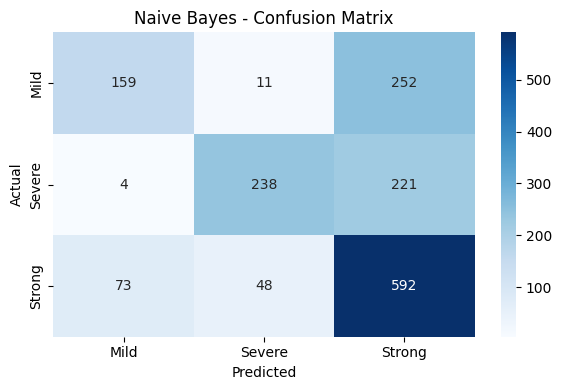


==== Logistic Regression ====
Accuracy:      0.7053
Precision:     0.7075
Recall:        0.7051 (Sensitivity)
Specificity:   0.8443
F1 Score:      0.7037

Classification Report:
              precision    recall  f1-score   support

        Mild       0.65      0.61      0.63       422
      Severe       0.78      0.81      0.80       463
      Strong       0.68      0.69      0.69       713

    accuracy                           0.71      1598
   macro avg       0.71      0.71      0.71      1598
weighted avg       0.70      0.71      0.70      1598



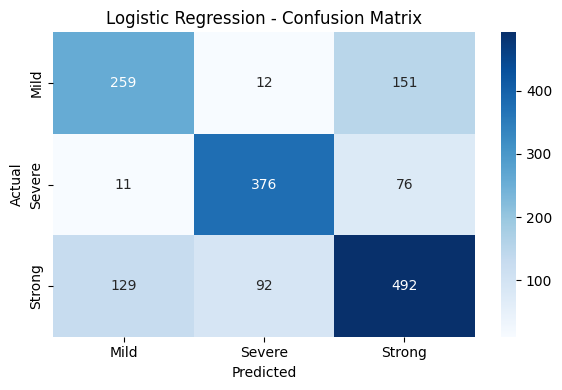


==== Random Forest ====
Accuracy:      0.7428
Precision:     0.7474
Recall:        0.7507 (Sensitivity)
Specificity:   0.8664
F1 Score:      0.7448

Classification Report:
              precision    recall  f1-score   support

        Mild       0.69      0.75      0.72       422
      Severe       0.80      0.81      0.80       463
      Strong       0.74      0.70      0.72       713

    accuracy                           0.74      1598
   macro avg       0.74      0.75      0.75      1598
weighted avg       0.74      0.74      0.74      1598



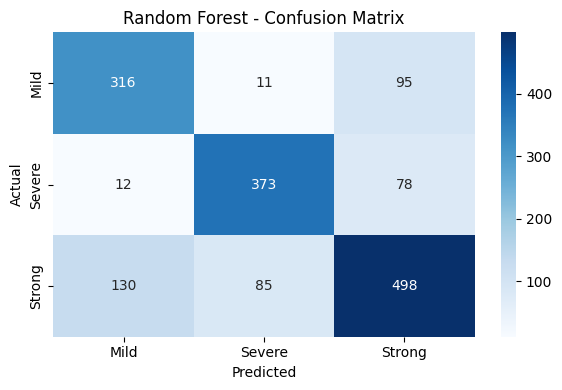


==== XGBoost ====
Accuracy:      0.7322
Precision:     0.7334
Recall:        0.7451 (Sensitivity)
Specificity:   0.8625
F1 Score:      0.7353

Classification Report:
              precision    recall  f1-score   support

        Mild       0.67      0.75      0.71       422
      Severe       0.78      0.82      0.80       463
      Strong       0.74      0.66      0.70       713

    accuracy                           0.73      1598
   macro avg       0.73      0.75      0.74      1598
weighted avg       0.73      0.73      0.73      1598



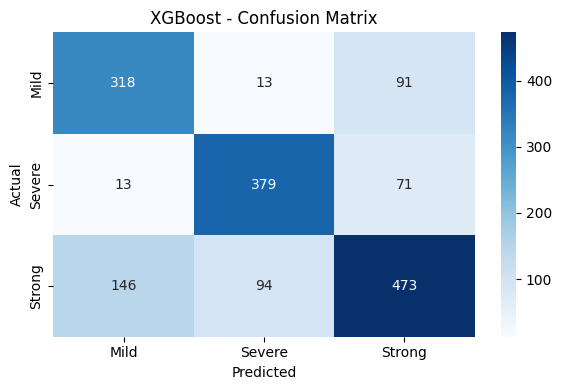


==== K-Nearest Neighbor ====
Accuracy:      0.6671
Precision:     0.6652
Recall:        0.6585 (Sensitivity)
Specificity:   0.8236
F1 Score:      0.6542

Classification Report:
              precision    recall  f1-score   support

        Mild       0.62      0.47      0.54       422
      Severe       0.72      0.82      0.77       463
      Strong       0.65      0.68      0.67       713

    accuracy                           0.67      1598
   macro avg       0.66      0.66      0.66      1598
weighted avg       0.66      0.67      0.66      1598



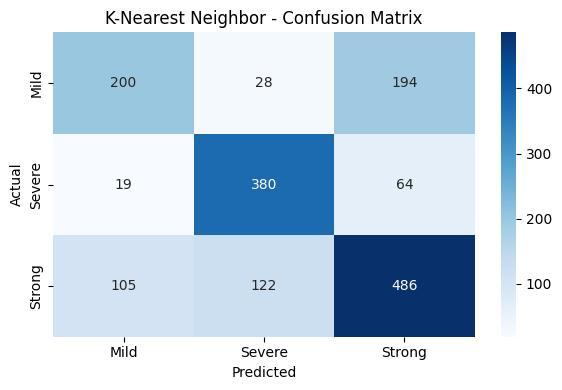

In [7]:
# Report results
for name, scores in results.items():
    print(f"\n==== {name} ====")
    avg_acc = np.mean(scores["accuracy"])
    avg_prec = np.mean(scores["precision"])
    avg_rec = np.mean(scores["recall"])
    avg_f1 = np.mean(scores["f1"])
    avg_spec = np.mean(scores["specificity"])

    print(f"Accuracy:      {avg_acc:.4f}")
    print(f"Precision:     {avg_prec:.4f}")
    print(f"Recall:        {avg_rec:.4f} (Sensitivity)")
    print(f"Specificity:   {avg_spec:.4f}")
    print(f"F1 Score:      {avg_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(scores["y_true"], scores["y_pred"], target_names=label_encoder.classes_))

    # Confusion matrix
    cm = confusion_matrix(scores["y_true"], scores["y_pred"])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

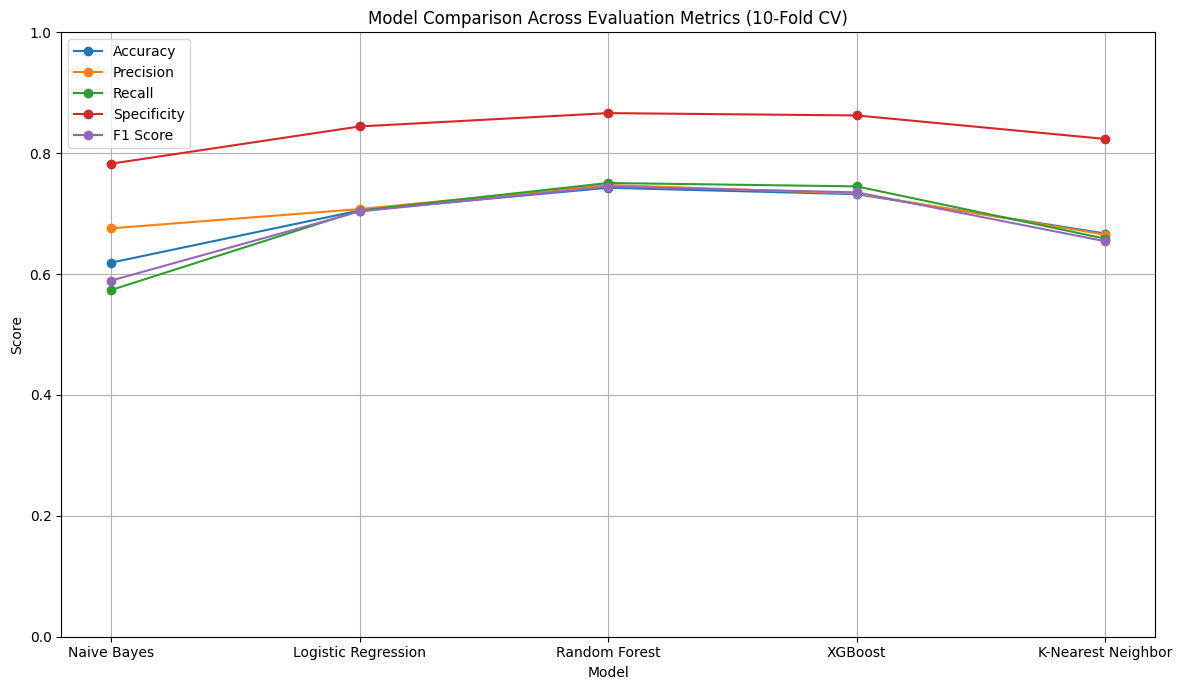

In [8]:
# Plot model comparison
metrics_summary = {
    name: {
        "Accuracy": np.mean(metrics["accuracy"]),
        "Precision": np.mean(metrics["precision"]),
        "Recall": np.mean(metrics["recall"]),
        "Specificity": np.mean(metrics["specificity"]),
        "F1 Score": np.mean(metrics["f1"]),
    }
    for name, metrics in results.items()
}

df_metrics = pd.DataFrame(metrics_summary).T.reset_index().rename(columns={"index": "Model"})

plt.figure(figsize=(12, 7))
for metric in ["Accuracy", "Precision", "Recall", "Specificity", "F1 Score"]:
    plt.plot(df_metrics["Model"], df_metrics[metric], marker='o', label=metric)

plt.title("Model Comparison Across Evaluation Metrics (10-Fold CV)")
plt.xlabel("Model")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()